In [1]:
import numpy as np
import pandas as pd

from random import randint
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input,Dense, AveragePooling2D,Conv2D, Conv2DTranspose,Flatten, MaxPooling2D, concatenate, Dropout,BatchNormalization,LeakyReLU,Activation,Add
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from tqdm import tqdm_notebook
from keras import backend as K
from keras import optimizers
import time

Using TensorFlow backend.


In [2]:
data_df = pd.read_csv('./Mixed_Df.csv',index_col=0)
data = data_df.sample(frac=1).reset_index(drop=True)

In [3]:
data.head()

,Img1,Valid_Img,Img2,Target
0,172_dt.jpg,172_d.jpg,189_dt.jpg,0
1,001_d.jpg,001_.jpg,019_dt.jpg,0
2,019_dt.jpg,019_d.jpg,009_t.jpg,0
3,038_t.jpg,038_.jpg,154_d.jpg,0
4,043_t.jpg,043_.jpg,043_dt.jpg,1


In [4]:
data = data[data['Target'] == 0]

In [5]:
img_path = '../cropped_GT'
imgs = os.listdir(img_path)

In [6]:
img_dic = {}
for img in imgs:
    img_dic[img] = np.array(load_img(img_path+'/'+img))/255
    print(img)
print('Read_Done')

140_d.jpg
016_dt.jpg
102_dt.jpg
054_t.jpg
171_d.jpg
164_.jpg
091_.jpg
048_t.jpg
020_dt.jpg
180_dt.jpg
177_dt.jpg
187_t.jpg
001_.jpg
064_dt.jpg
190_dt.jpg
118_dt.jpg
186_dt.jpg
064_.jpg
188_t.jpg
090_t.jpg
098_.jpg
179_t.jpg
033_d.jpg
052_d.jpg
048_d.jpg
160_d.jpg
066_dt.jpg
096_d.jpg
088_.jpg
152_d.jpg
136_t.jpg
143_.jpg
119_d.jpg
013_.jpg
006_.jpg
192_d.jpg
062_t.jpg
179_dt.jpg
193_t.jpg
172_.jpg
095_dt.jpg
019_.jpg
003_d.jpg
020_t.jpg
012_d.jpg
186_d.jpg
175_dt.jpg
184_t.jpg
022_.jpg
147_t.jpg
140_dt.jpg
126_.jpg
027_d.jpg
029_d.jpg
075_d.jpg
022_dt.jpg
130_.jpg
162_d.jpg
010_d.jpg
104_d.jpg
144_d.jpg
001_dt.jpg
004_t.jpg
040_dt.jpg
114_.jpg
151_d.jpg
094_d.jpg
072_dt.jpg
165_d.jpg
117_t.jpg
097_dt.jpg
169_dt.jpg
173_t.jpg
086_t.jpg
173_.jpg
072_d.jpg
120_dt.jpg
181_dt.jpg
031_.jpg
153_dt.jpg
080_t.jpg
128_t.jpg
070_d.jpg
094_t.jpg
123_.jpg
195_.jpg
063_.jpg
074_t.jpg
163_.jpg
056_t.jpg
060_d.jpg
122_dt.jpg
080_dt.jpg
042_dt.jpg
094_.jpg
071_dt.jpg
014_.jpg
141_.jpg
115_.jpg
178_dt.j

In [7]:
def Resblock_discriminator(layer_input,channels):
    h1 = Conv2D(channels,3,strides=1,padding='same')(layer_input)
    h1 = Activation('relu')(h1)
    h1 = Conv2D(channels,3,strides=1,padding='same')(h1)
    h1 = AveragePooling2D(pool_size=(2, 2))(h1)

    h2 = Conv2D(channels,1,strides=1,padding="valid")(layer_input)
    h2 = Activation('relu')(h2)
    h2 = AveragePooling2D(pool_size=(2, 2))(h2)
    return Add()([h2,h1])

def Resblock_discriminator_NP(layer_input,channels):
    h1 = Conv2D(channels,3,strides=1,padding='same')(layer_input)
    h1 = Activation('relu')(h1)
    h1 = Conv2D(channels,3,strides=1,padding='same')(h1)
    #h1 = AveragePooling2D(pool_size=(2, 2))(h1)

    h2 = Conv2D(channels,1,strides=1,padding="valid")(layer_input)
    h2 = Activation('relu')(h2)
    #h2 = AveragePooling2D(pool_size=(2, 2))(h2)
    return Add()([h2,h1])

In [8]:
def base_model(in_l):
    x = Conv2D(64,7,strides=2,padding='same')(in_l)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3),strides = 2)(x)
    
    x1 = Conv2D(64,3,padding='same')(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x2 = Conv2D(64,3,padding='same')(x1)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x = Add()([x,x2])
    x = Conv2D(128,3,padding='same')(x)
    #x = Conv2D(64,3,strides=2,padding='same')(x)
    """   
    x1 = Conv2D(128,3,padding='same')(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x2 = Conv2D(128,3,padding='same')(x1)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x = Add()([x,x2])
    x = MaxPooling2D(pool_size=(3, 3),strides = 2)(x)
    x = Conv2D(256,3,padding='same')(x)
    x1 = Conv2D(256,3,padding='same')(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x2 = Conv2D(256,3,padding='same')(x1)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x = Add()([x,x2])
    """
    x1 = Conv2D(128,3,padding='same')(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x2 = Conv2D(128,3,padding='same')(x1)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    
    x = Add()([x,x2])
    x = Conv2D(128,3,padding='same')(x)
    return x
input_tensor = Input(shape=(224, 224, 3))
out_tensor = base_model(input_tensor)

In [24]:
feature_map = Model(inputs = input_tensor,outputs = out_tensor)
feature_map.trainable = True

In [25]:
feature_map.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 112, 112, 64) 256         conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 112, 112, 64) 0           batch_normalization_16[0][0]     
__________________________________________________________________________________________________
max_poolin

In [26]:
def build_feature_map(input_layer1,input_layer2,input_layer3,model):
    x1 = model(input_layer1)
    x2 = model(input_layer2)
    x3 = model(input_layer3)
    x3 = concatenate([x1,x2,x3],axis = -1)
    return x3

input_layer1 = Input((224, 224, 3),name='input1' )
input_layer2 = Input((224, 224, 3),name='input2')
input_layer3 = Input((224, 224, 3),name='input3')

output_layer = build_feature_map(input_layer1,input_layer2,input_layer3,feature_map)

In [8]:

def triplet_loss(y_true, y_pred):
    """
    Triplet Loss
    """
    MARGIN = 1.0
    anc, pos, neg = y_pred[:,:,:, 0:128], y_pred[:,:,:, 128:256], y_pred[:,:,:, 256:]
    #anc, pos, neg = y_pred[:,:,:, 0:64], y_pred[:,:,:, 64:128], y_pred[:,:,:, 128:]
    # Euclidean Distance
    pos_dist = K.sum(K.square(anc - pos), axis=-1, keepdims=True)
    neg_dist = K.sum(K.square(anc - neg), axis=-1, keepdims=True)
    basic_loss = pos_dist - neg_dist + MARGIN

    loss = K.maximum(basic_loss, 0.0)

    print("[INFO] model - triplet_loss shape: %s" % str(loss.shape))
    return loss

In [31]:
model = Model(inputs = [input_layer1,input_layer2,input_layer3], outputs = output_layer)
model.summary()
model.trainable = True

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input3 (InputLayer)             (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 55, 55, 128)  601728      input1[0][0]                     
                                                                 input2[0][0]                     
          

In [32]:
model.compile(loss=triplet_loss, optimizer=Adam())

[INFO] model - triplet_loss shape: (?, 55, 55, 1)


In [33]:
data.shape

(1552, 4)

In [34]:
train_data = data.iloc[0:1550,:]

In [35]:
x_1 = np.array([img_dic[k] for k in train_data['Img1']])
x_2 = np.array([img_dic[k] for k in train_data['Valid_Img']])
x_3 = np.array([img_dic[k] for k in train_data['Img2']])
target = np.array(train_data['Target'])


In [36]:
#y_true = np.array([2000 * np.zeros((55,55,256))])
y_true = np.array([1550 * np.zeros((28,28,168))])

In [37]:
model_checkpoint = ModelCheckpoint("./saved_model/Tri_feature_55x55_128.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(patience=20, verbose=1)
model.fit(x=[x_1,x_2,x_3],
            y=target,validation_split = 0.2,
            batch_size=16, epochs=100,verbose=1,
            callbacks=[early_stopping, model_checkpoint,reduce_lr]
         )

Train on 1240 samples, validate on 310 samples
Epoch 1/100
1240/1240 [==============================] - 17s 13ms/step - loss: 2.3403 - val_loss: 1.1232

Epoch 00001: val_loss improved from inf to 1.12322, saving model to ./saved_model/Tri_feature_55x55_128.model
Epoch 2/100
1240/1240 [==============================] - 14s 11ms/step - loss: 0.7081 - val_loss: 0.7914

Epoch 00002: val_loss improved from 1.12322 to 0.79137, saving model to ./saved_model/Tri_feature_55x55_128.model
Epoch 3/100
1240/1240 [==============================] - 14s 12ms/step - loss: 0.6515 - val_loss: 0.7603

Epoch 00003: val_loss improved from 0.79137 to 0.76029, saving model to ./saved_model/Tri_feature_55x55_128.model
Epoch 4/100
1240/1240 [==============================] - 14s 12ms/step - loss: 0.6218 - val_loss: 0.6901

Epoch 00004: val_loss improved from 0.76029 to 0.69009, saving model to ./saved_model/Tri_feature_55x55_128.model
Epoch 5/100
1240/1240 [==============================] - 14s 12ms/step - loss

1240/1240 [==============================] - 15s 12ms/step - loss: 0.3033 - val_loss: 0.3886

Epoch 00043: val_loss did not improve from 0.38702
Epoch 44/100
1240/1240 [==============================] - 14s 12ms/step - loss: 0.3026 - val_loss: 0.3871

Epoch 00044: val_loss did not improve from 0.38702
Epoch 45/100
1240/1240 [==============================] - 14s 12ms/step - loss: 0.3053 - val_loss: 0.3845

Epoch 00045: val_loss improved from 0.38702 to 0.38446, saving model to ./saved_model/Tri_feature_55x55_128.model
Epoch 46/100
1240/1240 [==============================] - 15s 12ms/step - loss: 0.3022 - val_loss: 0.3900

Epoch 00046: val_loss did not improve from 0.38446
Epoch 47/100
1240/1240 [==============================] - 15s 12ms/step - loss: 0.2993 - val_loss: 0.3854

Epoch 00047: val_loss did not improve from 0.38446
Epoch 48/100
1240/1240 [==============================] - 14s 12ms/step - loss: 0.3060 - val_loss: 0.3878

Epoch 00048: val_loss did not improve from 0.38446
Ep

KeyboardInterrupt: 

## <font color='black'>Below Parts(until the next markdown) are used to extract feature map weights of the pretrained Tri model.Do not need to run except the first time.</font>

In [38]:
K.clear_session()

In [39]:
import gc

In [40]:
del y_true

In [41]:
gc.collect()

171

In [43]:
#feature_map2 = load_model('/home/wenjie/Desktop/earImageDataset/keras-frcnn-master.2/saved_model/Tri_feature.model',custom_objects={'triplet_loss':triplet_loss})
feature_map2 = load_model('./saved_model/Tri_feature_55x55_128.model',custom_objects={'triplet_loss':triplet_loss})

[INFO] model - triplet_loss shape: (?, 55, 55, 1)


In [44]:
feature_map2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input3 (InputLayer)             (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 55, 55, 128)  601728      input1[0][0]                     
                                                                 input2[0][0]                     
          

In [46]:
layer_output = feature_map2.get_layer('model_4')

In [47]:
layer_output.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 112, 112, 64) 256         conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 112, 112, 64) 0           batch_normalization_16[0][0]     
__________________________________________________________________________________________________
max_poolin

In [48]:
Input_layer = layer_output.get_layer('input_4')

In [49]:
Out_layer = layer_output.get_layer('conv2d_27')

In [50]:
feature_map = Model(inputs = Input_layer.input,outputs = Out_layer.output)

In [51]:
feature_map.get_weights()

[array([[[[-5.04958704e-02, -1.67689361e-02,  3.64595093e-02, ...,
           -2.75744218e-03,  1.19361160e-02, -4.28488255e-02],
          [ 7.13203568e-03, -1.17814988e-02,  1.04908375e-02, ...,
            3.12658660e-02, -2.67243646e-02, -2.56650262e-02],
          [ 1.91367622e-02, -1.48305651e-02, -1.37593225e-02, ...,
           -2.85451487e-03,  1.78414043e-02, -4.41925302e-02]],
 
         [[-4.26318981e-02, -2.42820662e-02,  3.14346440e-02, ...,
           -2.96893511e-02,  8.60006083e-03,  2.59364061e-02],
          [ 1.76009778e-02, -2.33276058e-02, -4.47028279e-02, ...,
            3.55998916e-03,  2.06897631e-02, -3.32516581e-02],
          [-1.96921341e-02, -3.37425843e-02,  4.67471555e-02, ...,
            4.92239334e-02,  8.26114975e-03, -4.45714742e-02]],
 
         [[-3.37622724e-02, -8.83228518e-03, -3.06207500e-03, ...,
            1.77063160e-02,  1.03157423e-02, -2.61973664e-02],
          [ 4.14339080e-02, -2.79797856e-02,  5.63382823e-03, ...,
            6.733

In [52]:
#feature_map.save('./saved_model/feature_map_model.model')
feature_map.save('./saved_model/feature_map_model_55x55_128_Ne.model')

## <font color='black'>Above Parts are used to extract feature map weights of the pretrained Tri model.Do not need to run except the first time.</font>

In [9]:
#feature_map = load_model('./saved_model/feature_map_model.model')
feature_map = load_model('./saved_model/feature_map_model_55x55_128_Ne.model')

/home/wenjie/anaconda3/envs/py36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
def build_model(input_layer1,input_layer2,model):
    x1 = model(input_layer1)
    x2 = model(input_layer2)
    x3 = concatenate([x1,x2],axis = -1)  
    x3 = Resblock_discriminator(x3,512)
    x3 = Dropout(0.4)(x3)
    x3 = Resblock_discriminator(x3,256)
    x3 = Dropout(0.4)(x3)
    #x3 = Resblock_discriminator(x3,256)
    x3 = Conv2D(256,3,strides=2,padding="same")(x3)
    #x3 = Dense(256)(x3)
    #x3 = Dense(125)(x3)
    x3 = Dense(128)(x3)
    x3 = Flatten()(x3)
    output = Dense(2)(x3)
    output = Activation('softmax')(output)
    return output

input1 = Input((224, 224, 3),name='input1' )
input2 = Input((224, 224, 3),name='input2')

cls_output_layer = build_model(input1,input2,feature_map)

In [11]:
cls_model = Model(inputs = [input1,input2], outputs = cls_output_layer)

cls_model.trainable = True
feature_map.trainable = False
cls_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 55, 55, 128)  601728      input1[0][0]                     
                                                                 input2[0][0]                     
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 55, 55, 256)  0           model_1[1][0]                    
          

In [12]:
loss = Adam(0.0001,0.5)
cls_model.compile(loss = 'categorical_crossentropy',optimizer = loss,metrics=["accuracy"])

In [13]:
data_df = pd.read_csv('./easy_more2.csv',index_col=0)
data = data_df.sample(frac=1).reset_index(drop=True)
img_path = '../cropped_GT'
#img_path = '../resized_cropped_detection'
#img_path = '../resized_detection_2'
imgs = os.listdir(img_path)
img_dic = {}
for img in imgs:
    img_dic[img] = np.array(load_img(img_path+'/'+img))/255
    print(img)
print('Read_Done')


140_d.jpg
016_dt.jpg
102_dt.jpg
054_t.jpg
171_d.jpg
164_.jpg
091_.jpg
048_t.jpg
020_dt.jpg
180_dt.jpg
177_dt.jpg
187_t.jpg
001_.jpg
064_dt.jpg
190_dt.jpg
118_dt.jpg
186_dt.jpg
064_.jpg
188_t.jpg
090_t.jpg
098_.jpg
179_t.jpg
033_d.jpg
052_d.jpg
048_d.jpg
160_d.jpg
066_dt.jpg
096_d.jpg
088_.jpg
152_d.jpg
136_t.jpg
143_.jpg
119_d.jpg
013_.jpg
006_.jpg
192_d.jpg
062_t.jpg
179_dt.jpg
193_t.jpg
172_.jpg
095_dt.jpg
019_.jpg
003_d.jpg
020_t.jpg
012_d.jpg
186_d.jpg
175_dt.jpg
184_t.jpg
022_.jpg
147_t.jpg
140_dt.jpg
126_.jpg
027_d.jpg
029_d.jpg
075_d.jpg
022_dt.jpg
130_.jpg
162_d.jpg
010_d.jpg
104_d.jpg
144_d.jpg
001_dt.jpg
004_t.jpg
040_dt.jpg
114_.jpg
151_d.jpg
094_d.jpg
072_dt.jpg
165_d.jpg
117_t.jpg
097_dt.jpg
169_dt.jpg
173_t.jpg
086_t.jpg
173_.jpg
072_d.jpg
120_dt.jpg
181_dt.jpg
031_.jpg
153_dt.jpg
080_t.jpg
128_t.jpg
070_d.jpg
094_t.jpg
123_.jpg
195_.jpg
063_.jpg
074_t.jpg
163_.jpg
056_t.jpg
060_d.jpg
122_dt.jpg
080_dt.jpg
042_dt.jpg
094_.jpg
071_dt.jpg
014_.jpg
141_.jpg
115_.jpg
178_dt.j

In [14]:
data.shape

(3892, 3)

In [15]:
train_data = data.iloc[0:3800,:]

In [16]:
x_1 = np.array([img_dic[k] for k in train_data['Img1']])
x_2 = np.array([img_dic[k] for k in train_data['Img2']])
#target = np.array(train_data['Target'])
target = [[0,0] for i in range(train_data.shape[0])]
s = np.array(train_data['Target'])
for i in range(train_data.shape[0]):
    target[i][1-s[i]] = 1
target = np.array(target)

In [17]:
#cls_model = load_model("./saved_model/Triplet_trainable_55x55.model")

In [18]:
x_1[0].shape

(224, 224, 3)

In [19]:
model_checkpoint = ModelCheckpoint("./saved_model/Triplet_untrainable_55x55_Ne.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0000001, verbose=1)
early_stopping = EarlyStopping(patience=5, verbose=1)
cls_model.fit(x=[x_1,x_2],
            y=target,validation_split = 0.2,
            batch_size=16, epochs=100,verbose=1,
            callbacks=[early_stopping, model_checkpoint,reduce_lr]
         )

Train on 3040 samples, validate on 760 samples
Epoch 1/100
3040/3040 [==============================] - 37s 12ms/step - loss: 0.7312 - acc: 0.5276 - val_loss: 0.6390 - val_acc: 0.7066

Epoch 00001: val_loss improved from inf to 0.63904, saving model to ./saved_model/Triplet_untrainable_55x55_Ne.model
Epoch 2/100
3040/3040 [==============================] - 35s 11ms/step - loss: 0.5737 - acc: 0.7007 - val_loss: 0.3776 - val_acc: 0.8711

Epoch 00002: val_loss improved from 0.63904 to 0.37760, saving model to ./saved_model/Triplet_untrainable_55x55_Ne.model
Epoch 3/100
3040/3040 [==============================] - 35s 12ms/step - loss: 0.3295 - acc: 0.8549 - val_loss: 0.2193 - val_acc: 0.9079

Epoch 00003: val_loss improved from 0.37760 to 0.21930, saving model to ./saved_model/Triplet_untrainable_55x55_Ne.model
Epoch 4/100
3040/3040 [==============================] - 35s 12ms/step - loss: 0.2031 - acc: 0.9164 - val_loss: 0.1725 - val_acc: 0.9263

Epoch 00004: val_loss improved from 0.2193

In [20]:
His = cls_model.history.history

In [21]:
His.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])

In [22]:
len(His['val_acc'])

20

In [24]:
x_axis = [_ for _ in range(20)]

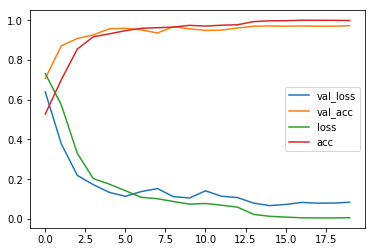

In [25]:
plt.plot(x_axis,His['val_loss'],label = 'val_loss')
plt.plot(x_axis,His['val_acc'],label = 'val_acc')
plt.plot(x_axis,His['loss'],label = 'loss')
plt.plot(x_axis,His['acc'],label = 'acc')
plt.legend()